In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten, Dropout, Input
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from google.colab import drive
import os
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
drive.mount('/content/drive', force_remount=True)
%ls

Mounted at /content/drive
drive/  sample_data/


In [3]:
%cd "drive/My Drive/ChiragBTP"
%ls

/content/drive/My Drive/ChiragBTP
 acf_1dcnn_v2.ipynb                'GUI for Audio Scene Recognition (1).ipynb'
 acf_awgn_features.py               models/
 acf_features.py                    plot_acf_features.py
 ACF_plots.ipynb                    plots/
 cnn_1d.py                          raw_data/
 cnn_1d_v2.py                       sandbox.ipynb
 cnn.py                             sets_labels/
 code/                              spectrogram_generator.py
'Confusion plots.ipynb'             split_audio_file.py
 create_ACF_train-test_sets.ipynb  'Splitting audio samples.ipynb'
 create_MFCC_dataset.py             svm.ipynb
 extract_features.py                svm.py
 feature_extraction.ipynb           Untitled.py
 features/


In [0]:
frame_size = 500
train_set_file = os.path.join('sets_labels', 'MFCC', '1hr', str(frame_size)+'ms', 'train_set.csv')
test_set_file = os.path.join('sets_labels', 'MFCC', '1hr', str(frame_size)+'ms', 'test_set.csv')
train_label_file = os.path.join('sets_labels', 'MFCC', '1hr', str(frame_size)+'ms', 'train_labels.csv')
test_label_file = os.path.join('sets_labels', 'MFCC', '1hr', str(frame_size)+'ms', 'test_labels.csv')

plot_file = os.path.join('plots', 'MFCC', '1D-CNN', str(frame_size)+'ms', '1d_cnn_v2.png')
weight_file = os.path.join('models','MFCC','1D-CNN', str(frame_size)+'ms', '1d_cnn_v2.hdf5')
info_file = os.path.join('models', 'MFCC', '1D-CNN', str(frame_size)+'ms', '1d_cnn_v2.txt')
scaler_file = os.path.join('models', 'MFCC', '1D-CNN', str(frame_size)+'ms', 'scaler_1d_cnn_v2.sav')

In [0]:
X_train = np.loadtxt(train_set_file)
X_test = np.loadtxt(test_set_file)
Y_train = np.loadtxt(train_label_file)
Y_test = np.loadtxt(test_label_file)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(Y_train.shape)
print(Y_test.shape)

joblib.dump(scaler, scaler_file)

(23416, 26)
(5855, 26)
(23416,)
(5855,)


['models/MFCC/1D-CNN/500ms/scaler_1d_cnn_v2.sav']

In [7]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(Y_train.shape)
print(Y_test.shape)

(23416, 26, 1)
(5855, 26, 1)
(23416, 4)
(5855, 4)


In [0]:
n_timesteps, n_features = X_train_scaled.shape[1], X_train_scaled.shape[2]
epochs, batch_size = 100, 128
optimizer = Adam()

In [0]:
def make_model(n_timesteps=None, n_features=None):
    model = Sequential()
    model.add(Conv1D(filters=60, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features), padding='same'))
    model.add(Conv1D(filters=60, kernel_size=2, activation='relu', padding='same'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2, stride =2))
    model.add(Conv1D(filters=80, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(filters=80, kernel_size=2, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [10]:
epochs_to_wait_for_improve = 1
model = make_model(n_timesteps=n_timesteps, n_features=n_features)
earlystopper = EarlyStopping(monitor='val_acc', patience=epochs_to_wait_for_improve, restore_best_weights=True)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 26, 60)            180       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 60)            7260      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 60)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 13, 80)            9680      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 13, 80)            12880     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1040)              0        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2, strides=2)`
  


In [11]:
hist = model.fit(X_train_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[earlystopper], validation_split=0.1)
model.save(weight_file)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 21074 samples, validate on 2342 samples
Epoch 1/100





21074/21074 [==============================] - 4s 210us/step - loss: 0.2885 - acc: 0.8864 - val_loss: 0.0285 - val_acc: 0.9915
Epoch 2/100
21074/21074 [==============================] - 1s 46us/step - loss: 0.0407 - acc: 0.9869 - val_loss: 0.0100 - val_acc: 0.9979
Epoch 3/100
21074/21074 [==============================] - 1s 44us/step - loss: 0.0265 - acc: 0.9925 - val_loss: 0.0065 - val_acc: 0.9983
Epoch 4/100
21074/21074 [==============================] - 1s 45us/step - loss: 0.0195 - acc: 0.9948 - val_loss: 0.0090 - val_acc: 0.9974


In [12]:
_, accuracy = model.evaluate(X_test_scaled, Y_test, batch_size=batch_size, verbose=1)
Y_pred = model.predict(X_test_scaled)
y_pred_labels = np.argmax(Y_pred, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)
conf_mat = confusion_matrix(y_test_labels, y_pred_labels)
clf_report = classification_report(y_test_labels, y_pred_labels)

5855/5855 [==============================] - 0s 22us/step


In [13]:
print("acc=%0.3f" % accuracy)
print(conf_mat)
print(clf_report)

acc=0.997
[[1438    0    6    4]
 [   1 1453    1    0]
 [   6    0 1501    0]
 [   0    0    0 1445]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1448
           1       1.00      1.00      1.00      1455
           2       1.00      1.00      1.00      1507
           3       1.00      1.00      1.00      1445

    accuracy                           1.00      5855
   macro avg       1.00      1.00      1.00      5855
weighted avg       1.00      1.00      1.00      5855



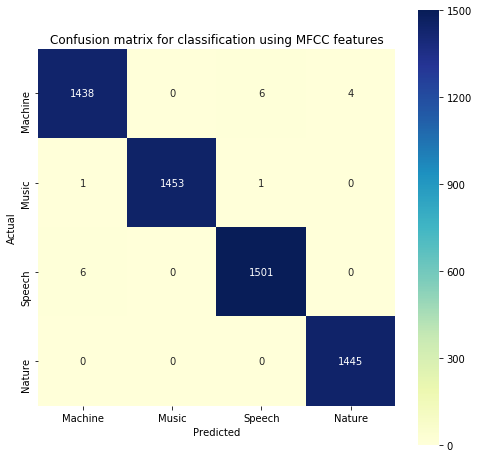

In [14]:
fig, ax = plt.subplots(figsize=(8,8))         
ax = sns.heatmap(conf_mat, annot=True, fmt='d', square=True, cmap="YlGnBu", 
                 xticklabels=['Machine', 'Music', 'Speech', 'Nature'], 
                 yticklabels=['Machine', 'Music', 'Speech', 'Nature'])
               
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix for classification using MFCC features')
#plt.show()
plt.savefig(plot_file)

In [0]:
file_obj = open(info_file, 'w')
# params = clf.get_params(deep=False)
# file_obj.write("PARAMETERS\n")
# for k in params.keys():
#   file_obj.write("{} : {}\n".format(k, params[k]))
file_obj.write("MODEL SUMMARY\n")
#summary = model.summary()
model.summary(print_fn=lambda x: file_obj.write(x + '\n'))
file_obj.write("\n")
file_obj.write("Optimizer : {}\n\n".format(str(optimizer)))

file_obj.write("\n\nTest accuracy = %0.3f\n\n" % accuracy)
file_obj.write("CLASSIFICATION REPORT\n")
file_obj.write(clf_report)

file_obj.write("\n\nFILE PATHS\n")
file_obj.write("Training set : {}\n".format(train_set_file))
file_obj.write("Testing set : {}\n".format(test_set_file))
file_obj.write("Weight file : {}\n".format(weight_file))
file_obj.write("Scaler file : {}\n".format(scaler_file))
file_obj.write("CM plot file : {}\n".format(plot_file))
file_obj.close()